A few things to pay attention when generating simulated data:
1. Keep `R`, `p`, `K_b` and `w_bp` the same as the null ones for each construct
2. Use the same `K_r` across all construct
3. Vary `w_rp` based on construct

In [1]:
## Python 3.11.3 environment
import numpy as np
import emcee
import matplotlib.pyplot as plt
import corner
import scipy.io

In [3]:
# Define the model function
def model_1bs(theta, Bcd, Runt):
    R, p, K_b, w_bp, K_r, w_rp = theta
    b = Bcd/K_b
    r = Runt/K_r
    Z = 1 + b**6 + r + r*b**6 + p + b**6*p*w_bp+ r*p*w_rp + r*b**6*p*w_bp*w_rp
    return R*((p + b**6*p*w_bp+ r*p*w_rp + r*b**6*p*w_bp*w_rp)/Z)

def model_1bs_null(theta, Bcd):
    R, p, K_b, w_bp = theta
    b = Bcd/K_b
    Z = 1 + b**6 + p + (b**6)*p*w_bp
    return R*((p + (b**6)*p*w_bp)/Z)

def add_noise(data, scale_factor=1e-5):
    scaled_data = data * scale_factor
    noise = np.random.poisson(scaled_data) / scale_factor
    return data + noise    

In [2]:
# Load the .mat file
data = scipy.io.loadmat('data.mat')
TFinput = scipy.io.loadmat('TFinput.mat')

# Access the Rate variables
data = data['data']

# Access the Transcription Factor inputs
TFinput = TFinput['TFinput']
Bcd = TFinput[:, 0]
Runt = TFinput[:, 1]
Runt_Null = TFinput[:, 2]

# Initialize an empty dictionary to store data for all constructs
all_constructs_data = {}

# Loop through each construct index
for construct_index in range(len(data[0])):
    # Get the construct name
    construct_name = data[0][construct_index]['constructName'][0]
    print(f"Processing Construct: {construct_name}")

    # Calculate the means and std for WT and Null rates
    Rate_WT_mean = np.nanmean(data[0][construct_index]['Rate_WT_individual'], axis=1)
    Rate_WT_std = np.nanstd(data[0][construct_index]['Rate_WT_individual'], axis=1)

    Rate_null_mean = np.nanmean(data[0][construct_index]['Rate_null_individual'], axis=1)
    Rate_null_std = np.nanstd(data[0][construct_index]['Rate_null_individual'], axis=1)

    APbins = data[0][construct_index]['APbins']

    ### Remove NaN Data points ###
    NoNaN_index_null = ~np.isnan(Rate_null_mean)
    NoNaN_index_WT = ~np.isnan(Rate_WT_mean)
    NoNaN_index_Bcd = ~np.isnan(Bcd)
    NoNaN_index_Runt = ~np.isnan(Runt)

    # Calculate the AP bins that are not NaNs in both WT and Null datasets
    NoNaN_index = NoNaN_index_null * NoNaN_index_WT * NoNaN_index_Bcd * NoNaN_index_Runt
    NoNaNindices = np.where(NoNaN_index)[0]

    # Truncate the vectors using the range of AP bins
    APbins = np.take(APbins, NoNaNindices)
    Rate_WT_mean = np.take(Rate_WT_mean, NoNaNindices)
    Rate_WT_std = np.take(Rate_WT_std, NoNaNindices)

    Rate_null_mean = np.take(Rate_null_mean, NoNaNindices)
    Rate_null_std = np.take(Rate_null_std, NoNaNindices)

    Bcd_truncated = np.take(Bcd, NoNaNindices)
    Runt_truncated = np.take(Runt, NoNaNindices)
    Runt_Null_truncated = np.take(Runt_Null, NoNaNindices)

    # Store the data for this construct in the dictionary
    all_constructs_data[construct_name] = {
        'APbins': APbins,
        'Rate_WT_mean': Rate_WT_mean,
        'Rate_WT_std': Rate_WT_std,
        'Rate_null_mean': Rate_null_mean,
        'Rate_null_std': Rate_null_std,
        'Bcd': Bcd_truncated,
        'Runt': Runt_truncated,
        'Runt_Null': Runt_Null_truncated
    }

# Print the final dictionary to verify
print(all_constructs_data['r0-new']['Rate_null_mean'])


Processing Construct: r0-new
Processing Construct: r1-new
Processing Construct: r2-new
Processing Construct: r3-new
Processing Construct: r1-close
Processing Construct: r1-mid
Processing Construct: r2_1+2
Processing Construct: r2_1+3
[129.4730657  134.26308205 138.28588192 124.28211245 138.98478723
 109.13995747  96.76845985  66.16162655  58.60518726  48.67311113]


/tmp/ipykernel_2452590/3653306276.py:24: RuntimeWarning: Mean of empty slice
  Rate_WT_mean = np.nanmean(data[0][construct_index]['Rate_WT_individual'], axis=1)
/mnt/Data1/Josh/miniforge3/envs/transcription_pipeline/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_2452590/3653306276.py:27: RuntimeWarning: Mean of empty slice
  Rate_null_mean = np.nanmean(data[0][construct_index]['Rate_null_individual'], axis=1)


In [8]:
K_r = 0.1

theta_r1close_null = np.array([1, 100, 10, 10])
theta_r1mid_null = 2*theta_r1close_null
theta_r1far_null = 3*theta_r1close_null

theta_r1close = np.hstack((theta_r1close_null, [K_r, 100]))
theta_r1mid = np.hstack((theta_r1mid_null, [K_r, 50]))
theta_r1far = np.hstack((theta_r1close_null, [K_r, 10]))

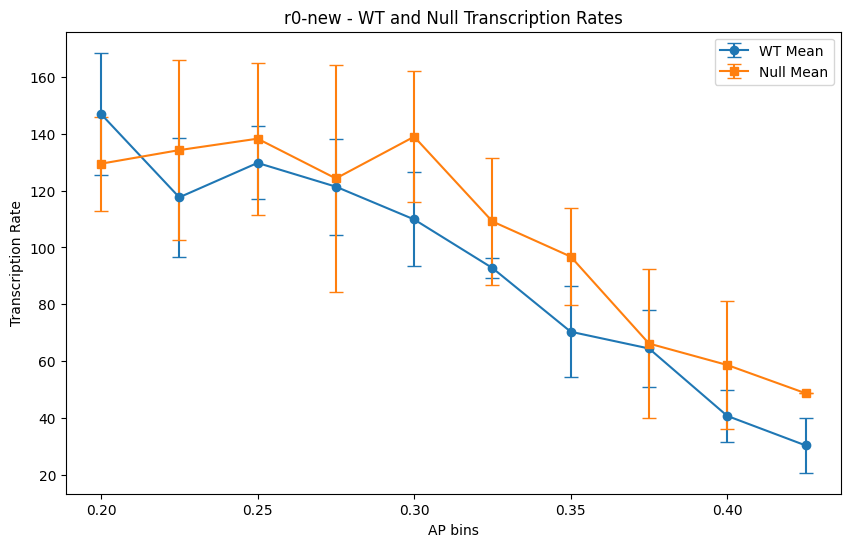

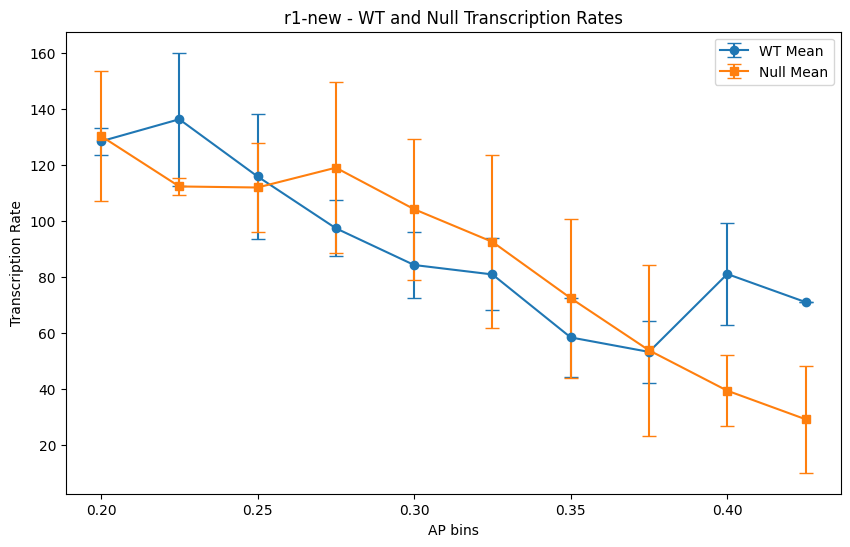

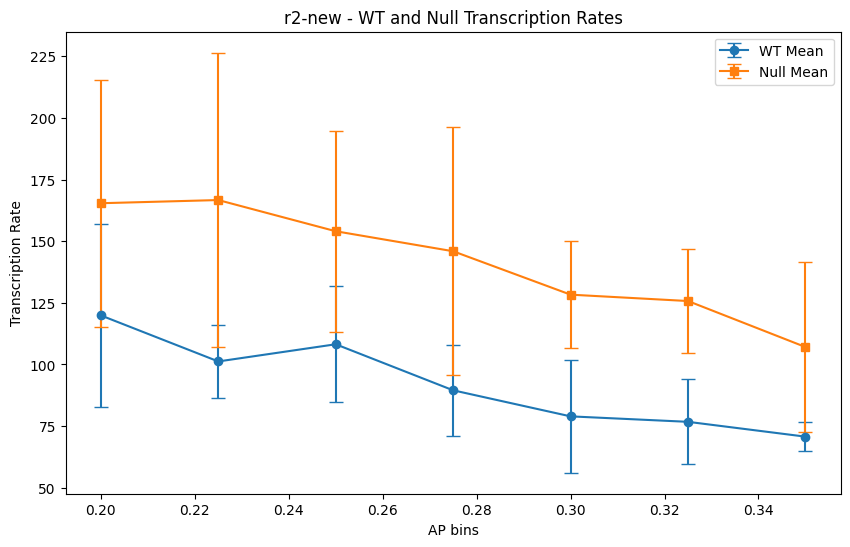

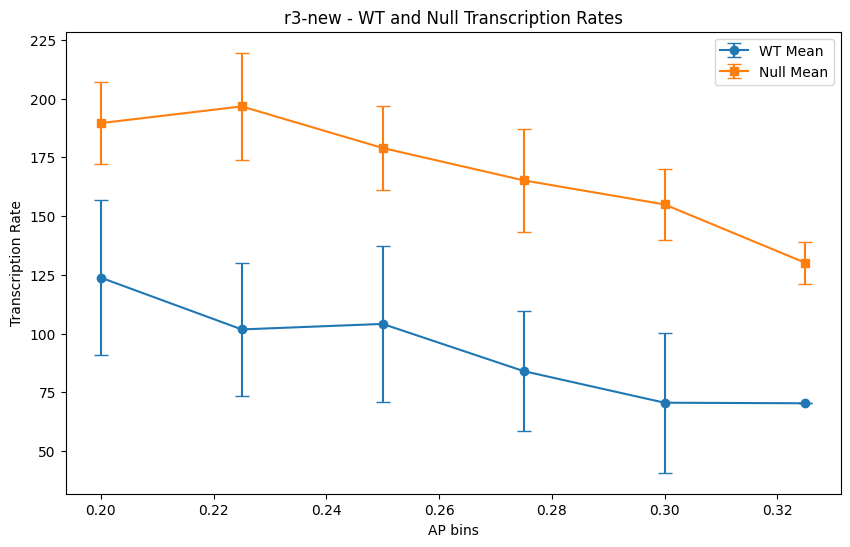

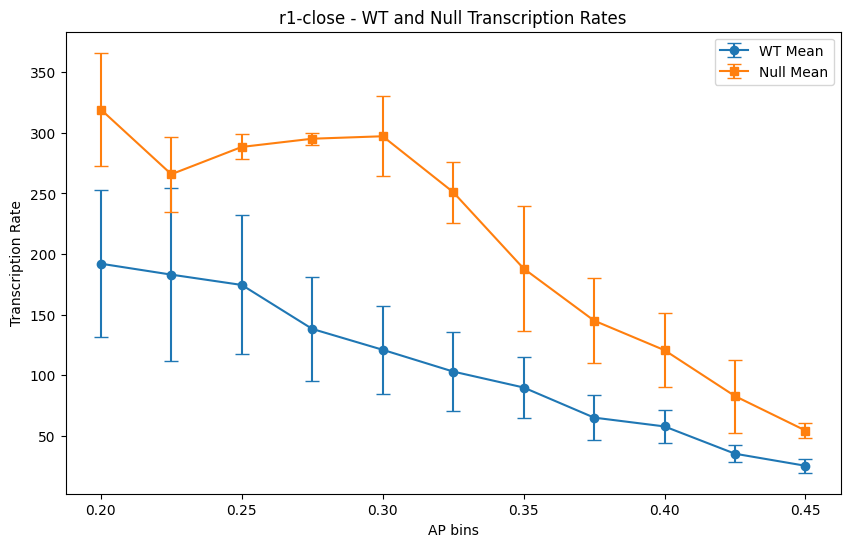

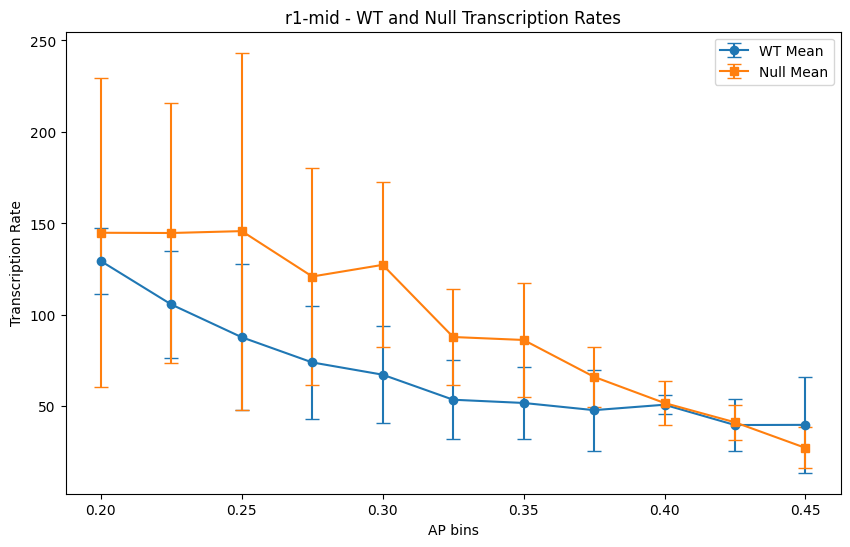

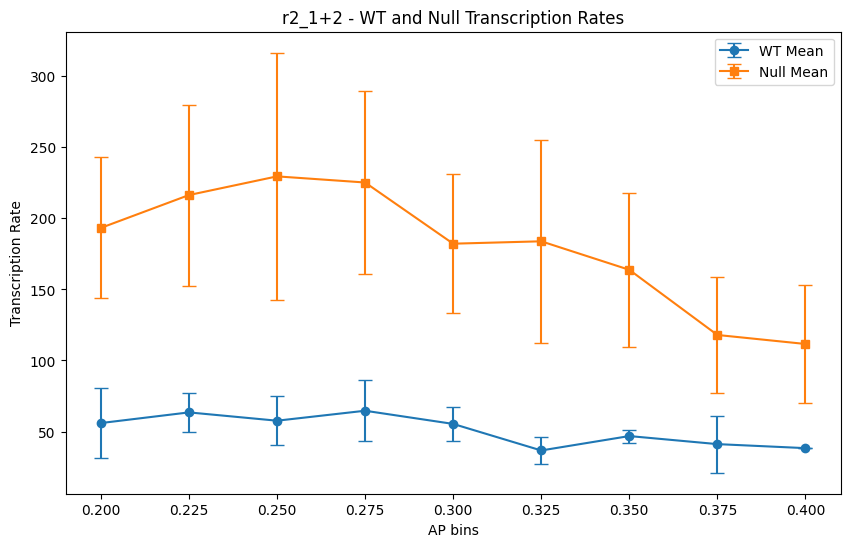

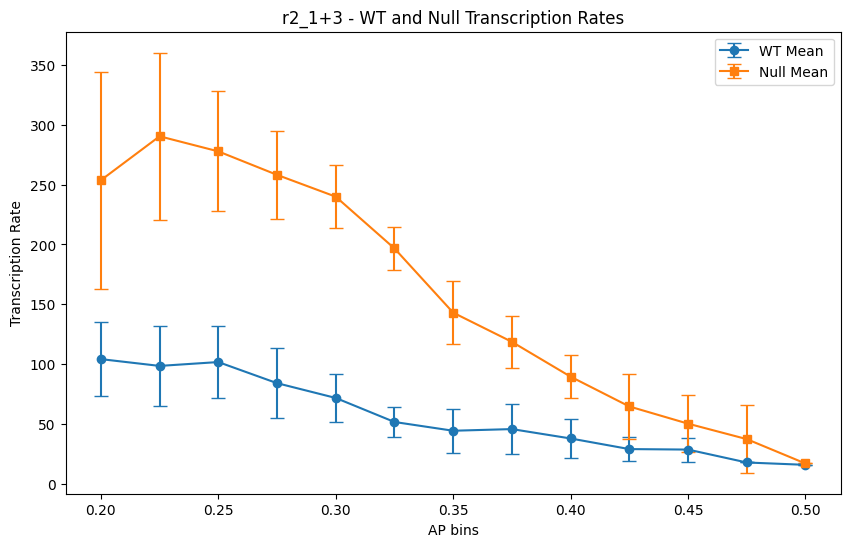

In [3]:
import matplotlib.pyplot as plt

# Create a plot for each construct
for construct_name, data_dict in all_constructs_data.items():
    APbins = data_dict['APbins']
    Rate_WT_mean = data_dict['Rate_WT_mean']
    Rate_WT_std = data_dict['Rate_WT_std']
    Rate_null_mean = data_dict['Rate_null_mean']
    Rate_null_std = data_dict['Rate_null_std']

    # Create a new figure for each construct
    plt.figure(figsize=(10, 6))

    # Plot WT data with error bars (mean ± std)
    plt.errorbar(APbins, Rate_WT_mean, yerr=Rate_WT_std, label='WT Mean', fmt='-o', capsize=5)

    # Plot Null data with error bars (mean ± std)
    plt.errorbar(APbins, Rate_null_mean, yerr=Rate_null_std, label='Null Mean', fmt='-s', capsize=5)

    # Add labels and title
    plt.title(f'{construct_name} - WT and Null Transcription Rates')
    plt.xlabel('AP bins')
    plt.ylabel('Transcription Rate')
    plt.legend()

    # Show the plot
    plt.show()


In [52]:
# Define the model function
def model_1bs(theta, Bcd, Runt):
    R, p, K_b, w_bp, K_r, w_rp = theta
    b = Bcd/K_b
    r = Runt/K_r
    Z = 1 + b**6 + r + r*b**6 + p + b**6*p*w_bp+ r*p*w_rp + r*b**6*p*w_bp*w_rp
    return R*((p + b**6*p*w_bp+ r*p*w_rp + r*b**6*p*w_bp*w_rp)/Z)

def model_1bs_null(theta, Bcd):
    R, p, K_b, w_bp = theta
    b = Bcd/K_b
    Z = 1 + b**6 + p + (b**6)*p*w_bp
    return R*((p + (b**6)*p*w_bp)/Z)


# Define the log-likelihood function
def log_likelihood(theta, model, Bcd, Rate):
    model_y = model(theta, Bcd)
    return -0.5 * np.sum((Rate - model_y)**2)

# Define the log-prior function
# Define the log-prior function using a Gaussian prior
# def log_prior(theta):
#     # Mean and standard deviation for the Gaussian prior
#     mu = np.array([200, 0.5, 10, 100])  # Example means for each parameter
#     sigma = np.array([50, 0.2, 5, 50])  # Example standard deviations for each parameter

#     R, p, K_b, w_bp = theta

#     # Compute log probability for each parameter
#     log_prior_value = (
#         -0.5 * np.sum(((theta - mu) / sigma) ** 2)  # Gaussian prior
#     )

#     # Additionally enforce parameter bounds
#     if (50 < R < 400) and (0.0001 < p < 1) and (0.1 < K_b < 100) and (0 < w_bp < 1000):
#         return log_prior_value
#     else:
#         return -np.inf

def log_prior(theta):
    R, p, K_b, w_bp = theta
    if (50 < R < 400) and (0.0001 < p < 1) and (0.1 < K_b < 100) and (0 < w_bp < 1000):
        return 0.0
    else:
        return -np.inf

# Define the log-posterior function
def log_posterior(theta, model, Bcd, Rate):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + log_likelihood(theta, model, Bcd, Rate)

In [39]:
# Create a dictionary to store the results for each construct
fit_results = {}
ndim = 4
nwalkers = 200
theta0 = [100, 0.1, 10, 50]

# Iterate through each construct in all_constructs_data
for construct_name, data_dict in all_constructs_data.items():
    print(f"Fitting construct: {construct_name} using Null model")

    # Extract Bcd, Runt, and Rate_null_mean from all_constructs_data
    Bcd = data_dict['Bcd']
    Runt = data_dict['Runt']
    Rate_null_mean = data_dict['Rate_null_mean']
    Rate_null_std = data_dict['Rate_null_std']

    # Set up the sampler for Null model to infer K_b, w_bp, R, p
    pos = [theta0 + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(model_1bs_null, Bcd, Rate_null_mean))

    # Burn-in phase
    pos, _, _ = sampler.run_mcmc(pos, 1000)

    # Production phase loop (repeat the production phase 3 times)
    for i in range(3):
        sampler.reset()
        sampler.run_mcmc(pos, 2000)

        # Extract the samples
        samples = sampler.get_chain(flat=True)
        
        # Update initial guess for the next iteration
        theta0 = np.median(samples, axis=0)
        pos = [theta0 + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]

    # Run the sampler for the final time
    sampler.reset()
    sampler.run_mcmc(pos, 10000)

    # Extract the samples
    samples = sampler.get_chain(flat=True)
    
    # Update initial guess for the next iteration
    theta0 = np.median(samples, axis=0)
    
    # Save the inferred parameters and samples for this construct
    fit_results[construct_name] = {
        'theta': theta0,
        'samples': samples
    }
    print(f"\t params: {theta0}")

# Save the inferred parameters for future use
inferred_parameters = {name: fit_results[name]['theta'] for name in all_constructs_data}


Fitting construct: r0-new using Null model
	 params: [141.73739465   0.2631686   92.07636509 227.5187102 ]
Fitting construct: r1-new using Null model
	 params: [1.27573480e+02 1.33464787e-01 9.16986244e+01 3.08905099e+02]
Fitting construct: r2-new using Null model
	 params: [205.35375614   0.89132951  79.48222646   5.95232087]
Fitting construct: r3-new using Null model
	 params: [209.14015813   0.87656911  92.0026607   22.18157626]
Fitting construct: r1-close using Null model
	 params: [3.12787666e+02 1.37137203e-01 9.20488080e+01 4.30404896e+02]
Fitting construct: r1-mid using Null model
	 params: [1.94608497e+02 1.67655094e-01 6.60657922e+01 1.97085392e+01]
Fitting construct: r2_1+2 using Null model
	 params: [223.58097225   0.38520833  91.78648738 174.01975749]
Fitting construct: r2_1+3 using Null model
	 params: [2.92555229e+02 1.14760851e-01 9.22436430e+01 3.29678600e+02]


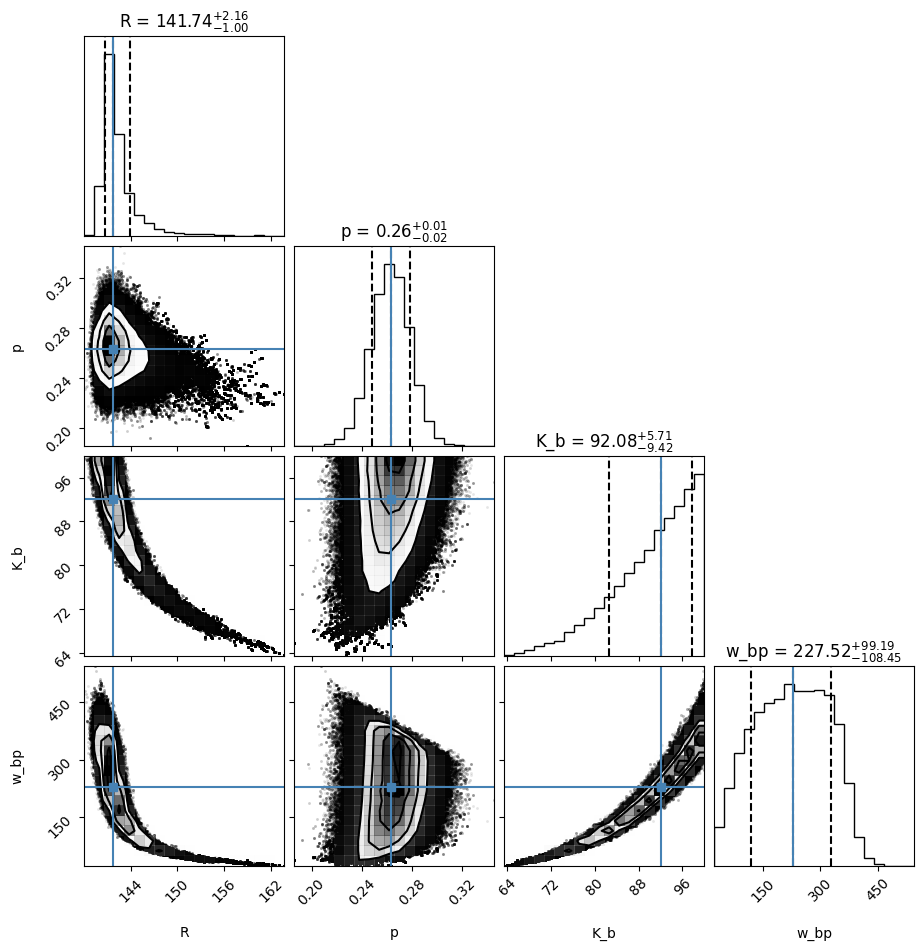

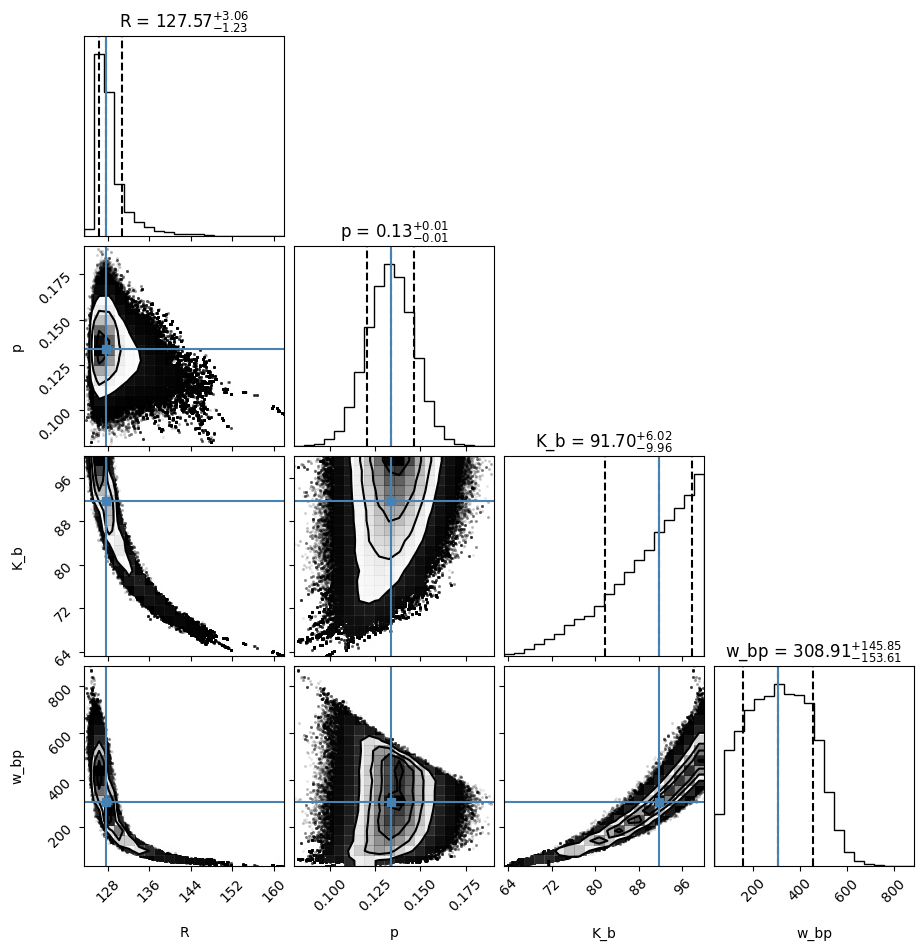

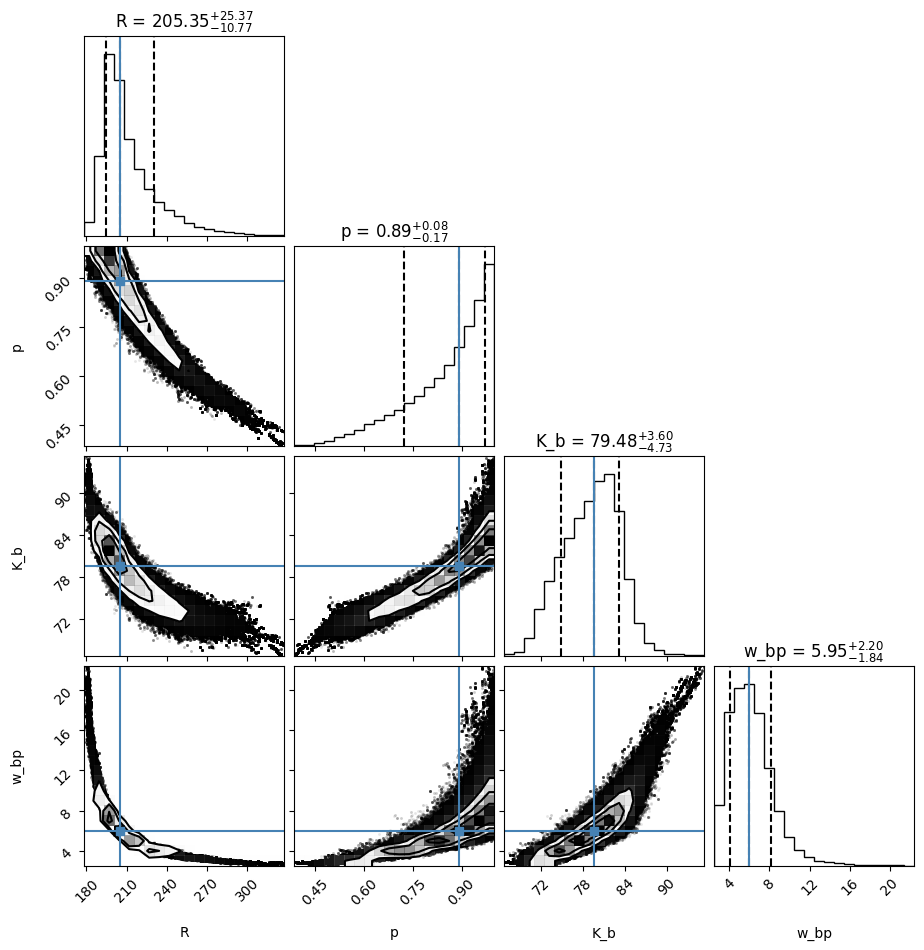

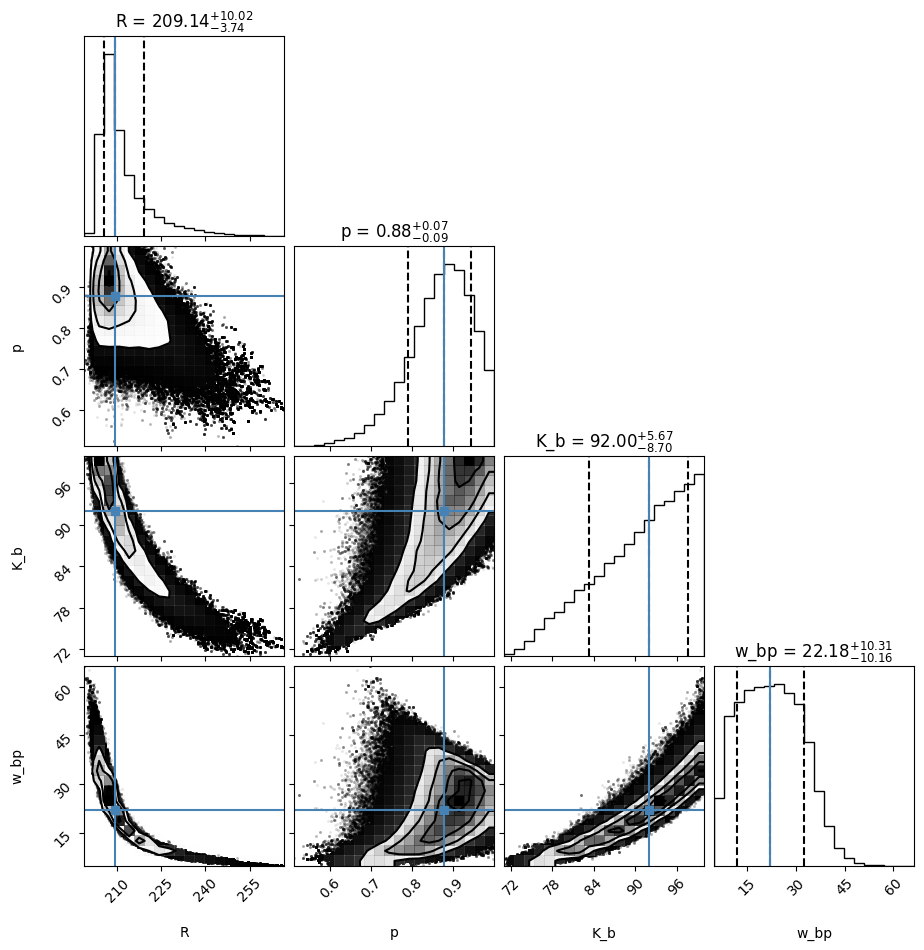

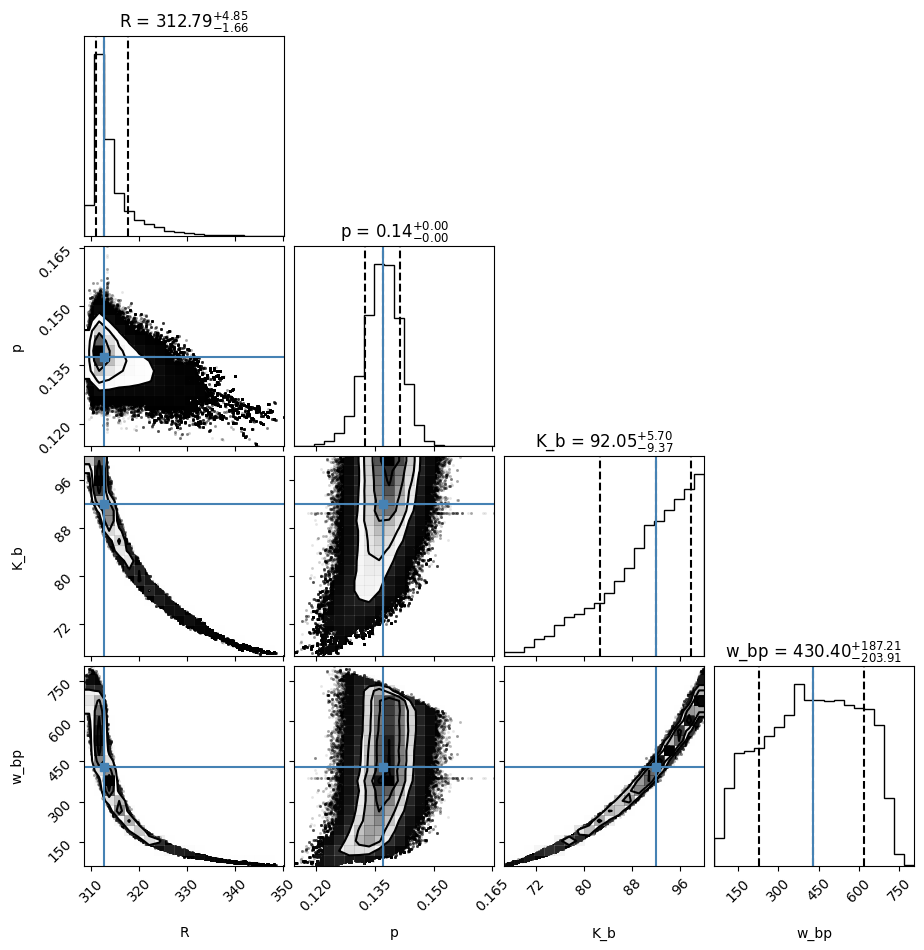

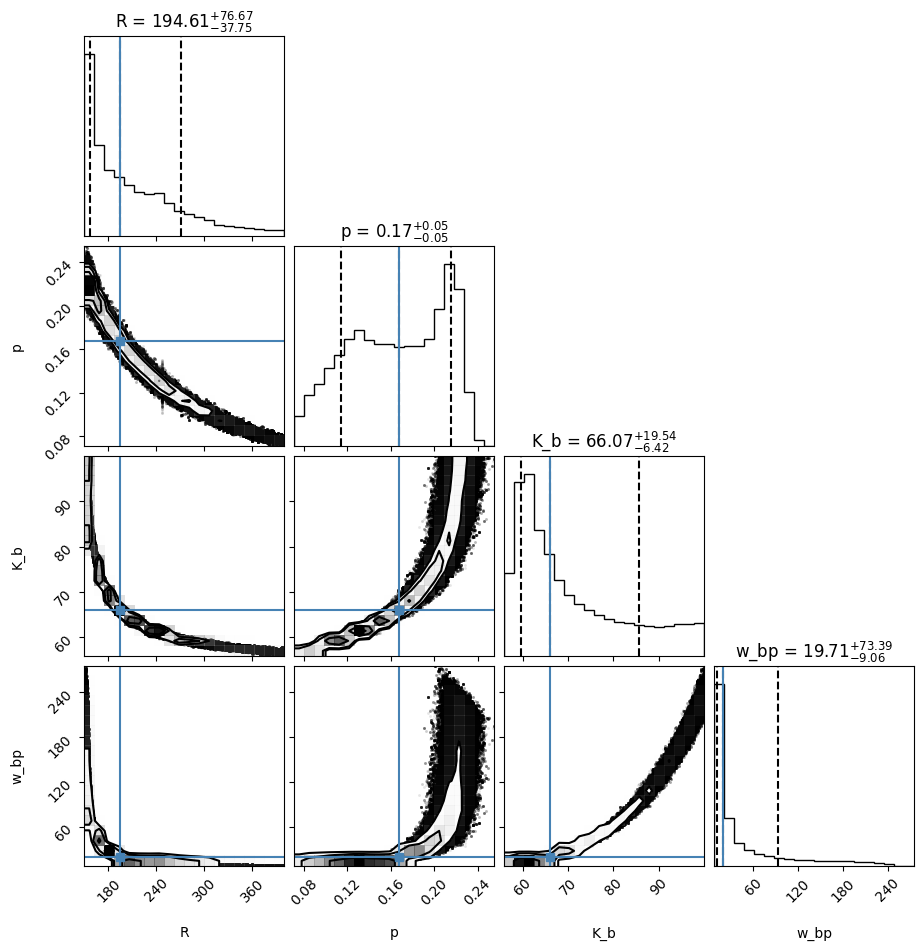

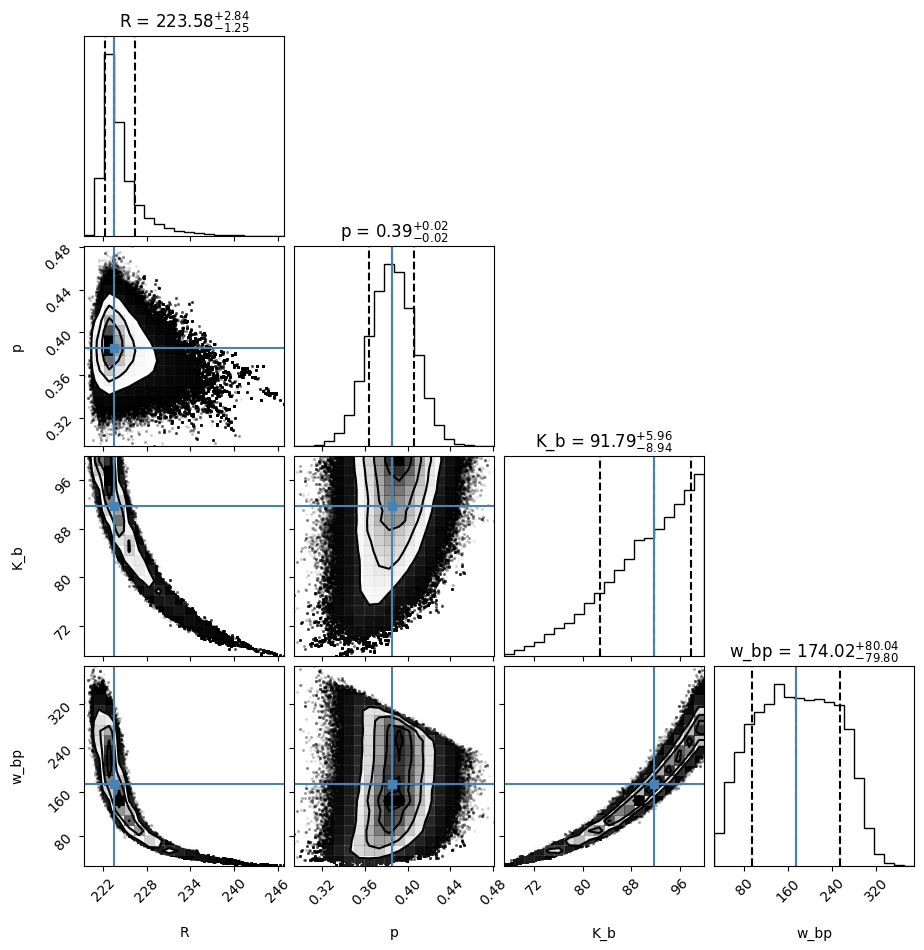

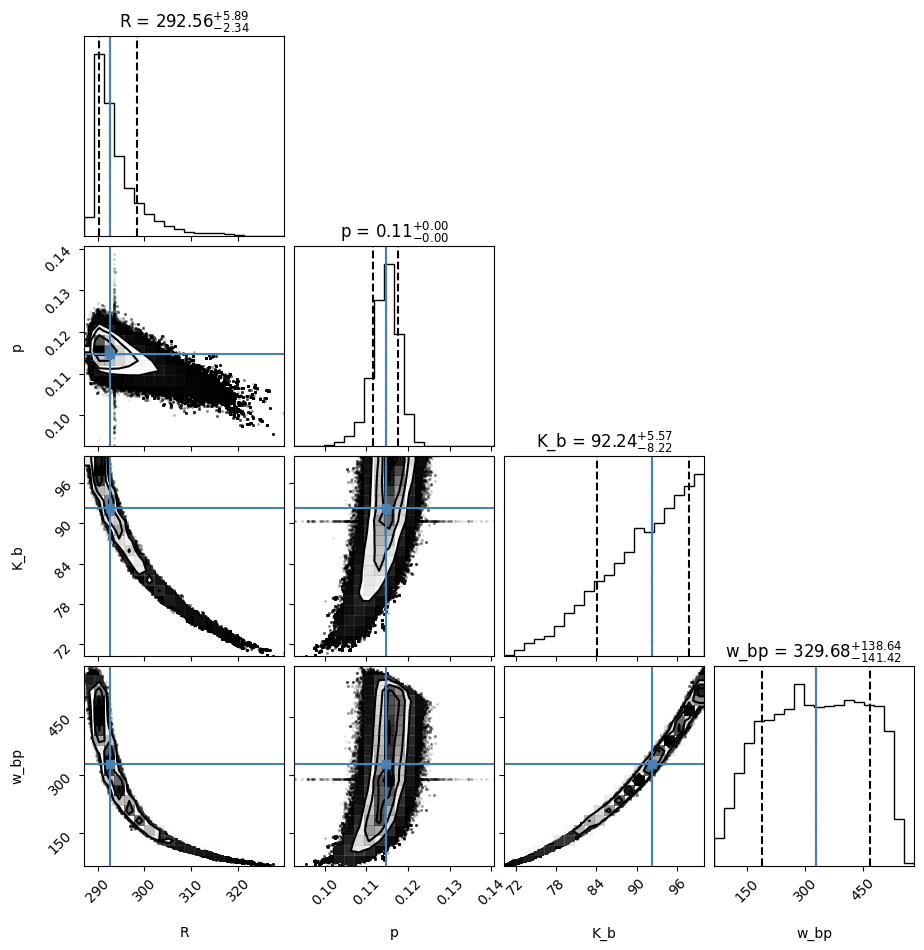

In [40]:
# Plot the parameter distributions for each construct
for construct_name, data_dict in all_constructs_data.items():
    theta = fit_results[construct_name]['theta']
    samples = fit_results[construct_name]['samples']

    # Create a corner plot
    fig = corner.corner(samples, labels=['R', 'p', 'K_b', 'w_bp'], truths=theta, quantiles=[0.16, 0.5, 0.84], show_titles=True)

    # Save the figure
    fig.savefig(f'{construct_name}_corner_plot.png')

    # Show the plot
    plt.show()



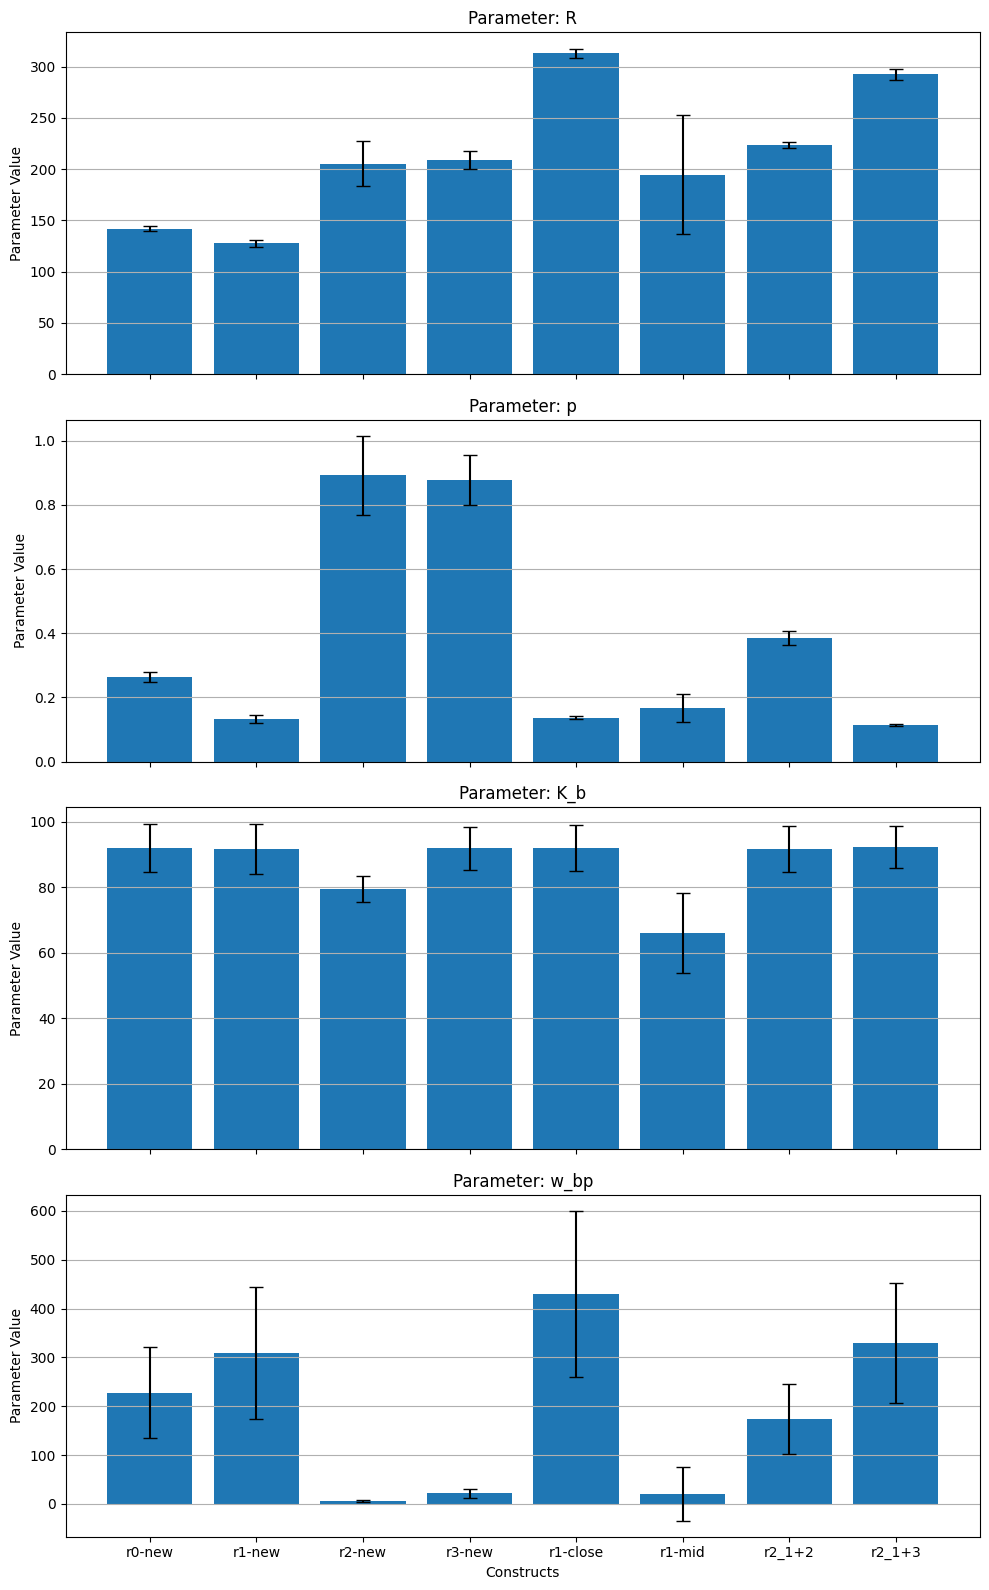

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming fit_results and all_constructs_data are already defined as in previous cells

# Extract the parameter means and standard deviations for each construct
means = np.array([fit_results[name]['theta'] for name in all_constructs_data])
stds = np.array([np.std(fit_results[name]['samples'], axis=0) for name in all_constructs_data])

# Define the parameter names
param_names = ['R', 'p', 'K_b', 'w_bp']

# Create a figure for the bar plots
num_params = len(param_names)
fig, axes = plt.subplots(num_params, 1, figsize=(10, 4 * num_params), sharex=True)

# Create a bar plot for each parameter
for i, param_name in enumerate(param_names):
    axes[i].bar(np.arange(len(all_constructs_data)), means[:, i], 
                 yerr=stds[:, i], capsize=5)
    axes[i].set_title(f'Parameter: {param_name}')
    axes[i].set_ylabel('Parameter Value')
    axes[i].set_xticks(np.arange(len(all_constructs_data)))
    axes[i].set_xticklabels(list(all_constructs_data.keys()))
    axes[i].grid(axis='y')  # Add grid lines for better readability

# Set common x-label for the constructs
axes[-1].set_xlabel('Constructs')

# Adjust layout
plt.tight_layout()
plt.show()


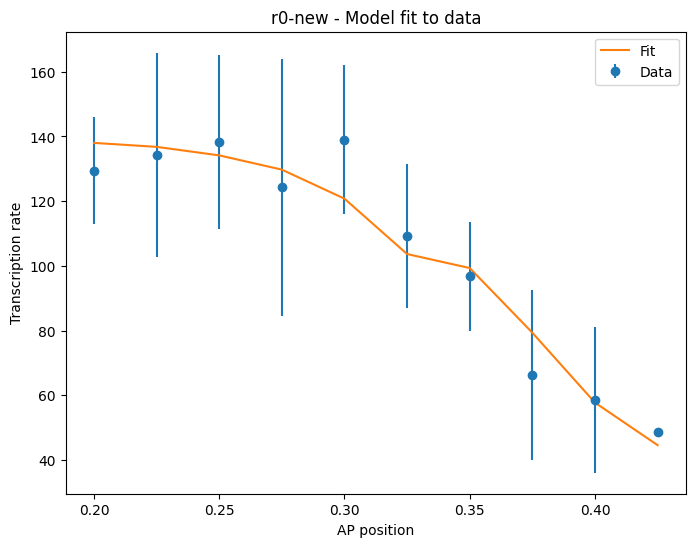

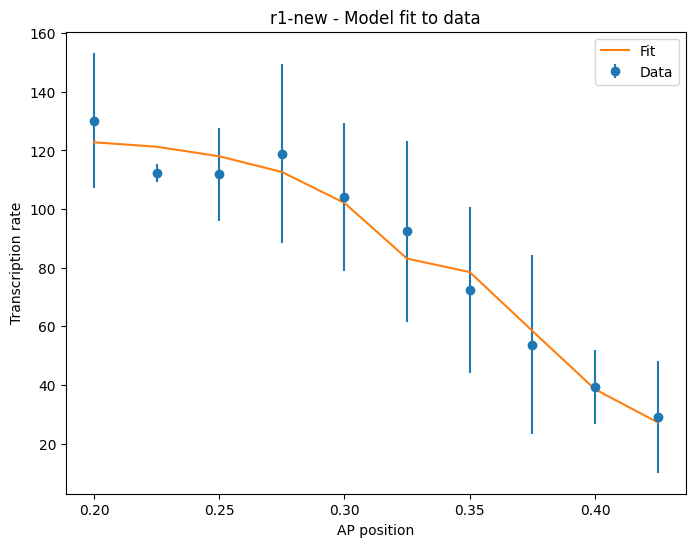

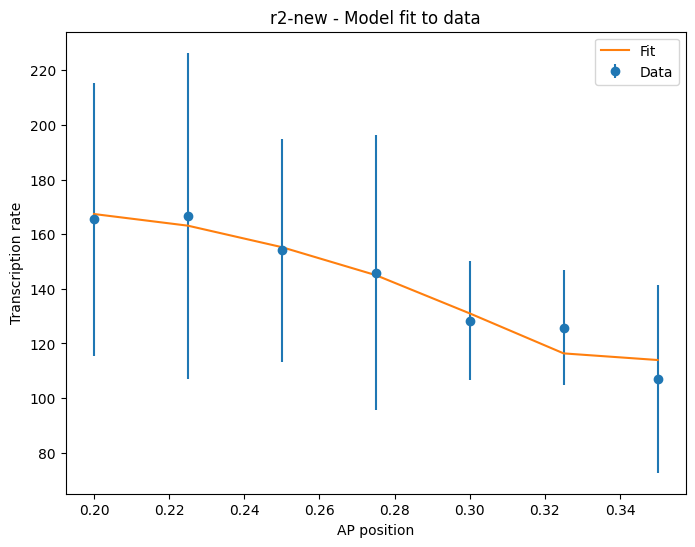

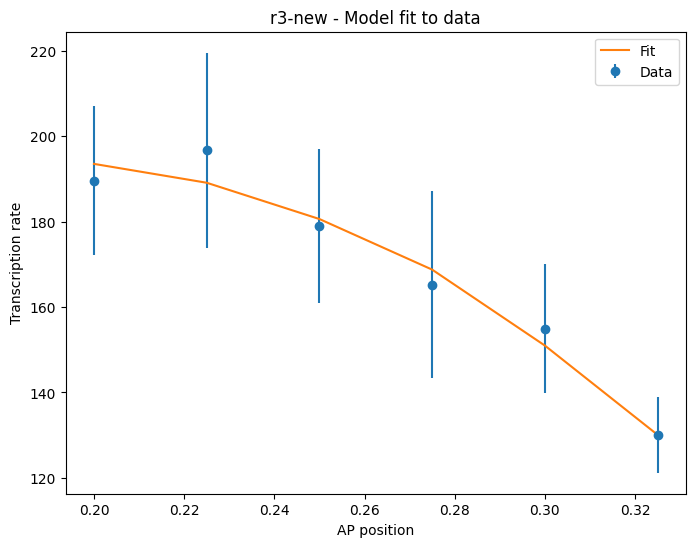

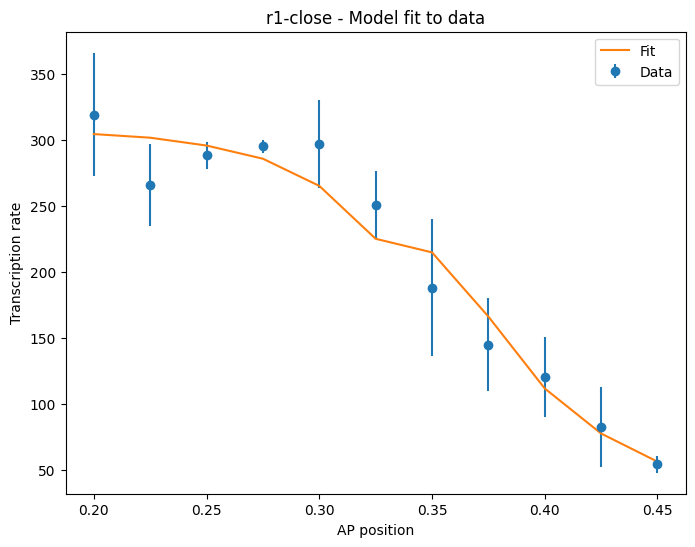

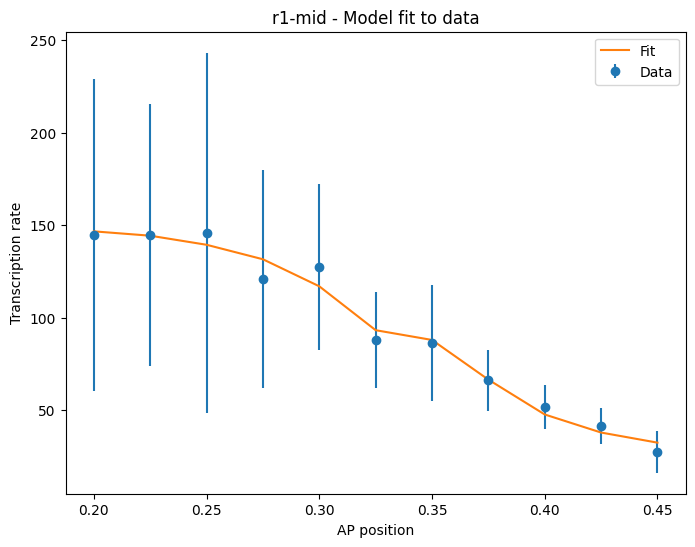

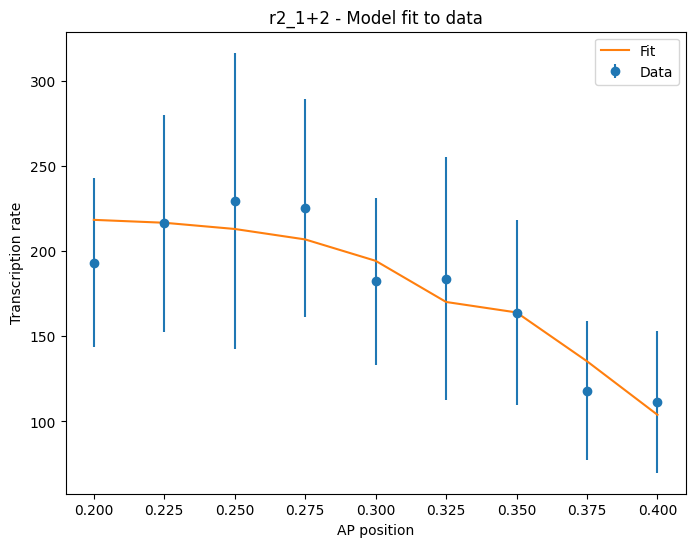

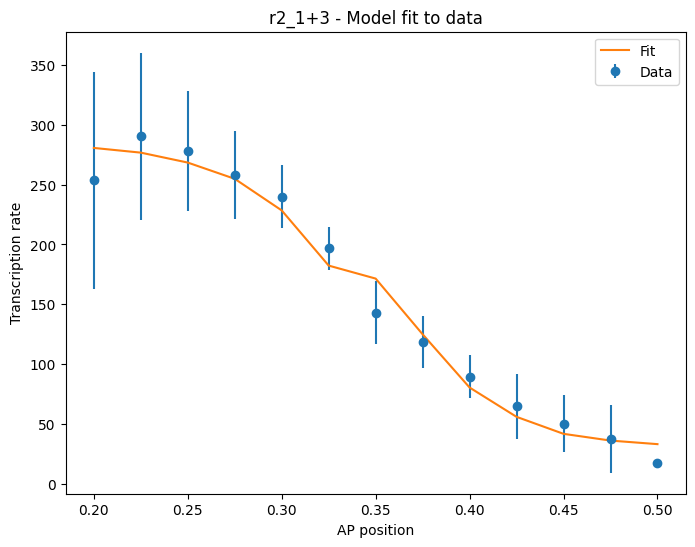

In [42]:
# Plot the data and their fits as a function of AP position
def plot_fits(data_dict, model, theta, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))

    # Extract the data
    Bcd = data_dict['Bcd']
    Runt = data_dict['Runt']
    Rate_null_mean = data_dict['Rate_null_mean']
    APbins = data_dict['APbins']

    # Compute the model fit
    Rate_fit = model(theta, Bcd)

    # Plot the data and the fit
    ax.errorbar(APbins, Rate_null_mean, yerr=data_dict['Rate_null_std'], fmt='o', label='Data')
    ax.plot(APbins, Rate_fit, label='Fit')

    # Add labels and title
    ax.set_xlabel('AP position')
    ax.set_ylabel('Transcription rate')
    ax.set_title('Model fit to data')
    ax.legend()

    return ax

# Plot the fits for each construct
for construct_name, data_dict in all_constructs_data.items():
    # Get the inferred parameters for this construct
    theta = inferred_parameters[construct_name]

    # Create a plot for this construct
    fig, ax = plt.subplots(figsize=(8, 6))
    ax = plot_fits(data_dict, model_1bs_null, theta, ax=ax)

    # Add the construct name to the plot
    ax.set_title(f'{construct_name} - Model fit to data')

    # Show the plot
    plt.show()

    


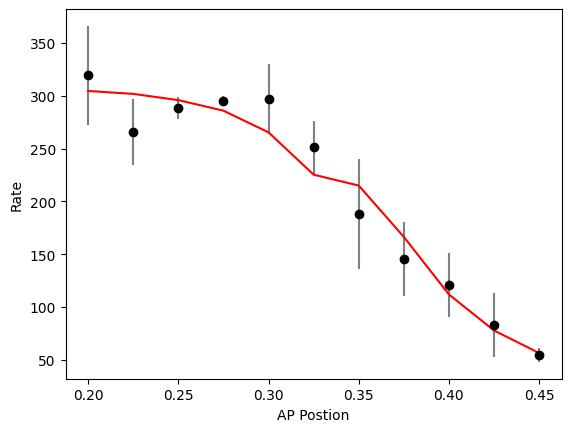

[3.12694504e+02 1.37273856e-01 9.23562705e+01 4.39377209e+02
 4.93392240e+01 6.01191718e-01]


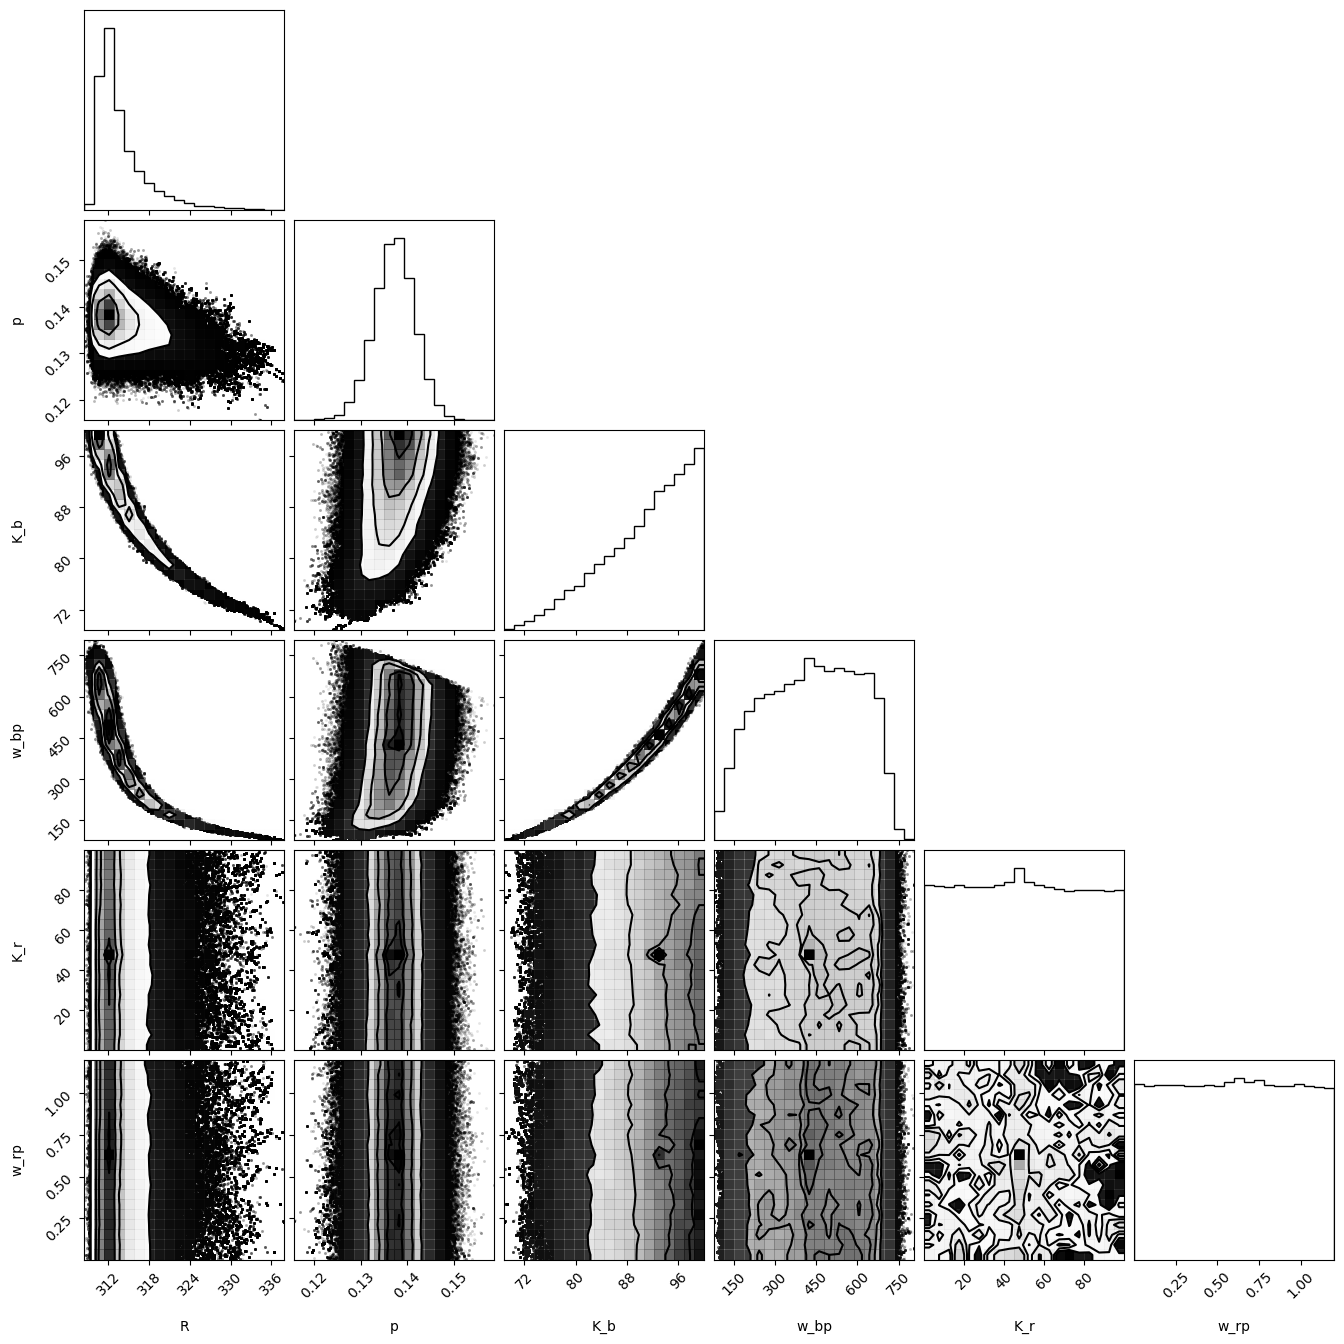

In [ ]:
# # Set up the sampler
# ndim = 6
# nwalkers = 200
# theta0 = [100, 0.1, 10, 50, 5, 0.5]


# # # R, p, K_b, w_bp, K_r, w_rp
# # cov = np.diag([1, 0.01, 0.1, 1, 0.1, 0.1])**2  # Covariance matrix
# # move = emcee.moves.GaussianMove(cov)

# pos = [theta0 + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
# sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(model_1bs_null, Bcd, Runt, Rate_null_mean))

# # Burn-in phase
# pos, _, _ = sampler.run_mcmc(pos, 10000)

# # Production phase
# for i in range(3):
#     sampler.reset()
#     sampler.run_mcmc(pos, 20000)

#     # Extract the samples
#     samples = sampler.get_chain(flat=True)
    
#     theta0 = np.median(samples, axis=0)
#     pos = [theta0 + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# # Plot the data and the model
# fig, ax = plt.subplots()
# ax.errorbar(APbins, Rate_null_mean, yerr=Rate_null_std, fmt='o', color='k', ecolor='gray', capsize=0)
# theta_best = np.median(samples, axis=0)
# Rate_fit = model_1bs_null(theta_best, Bcd, Runt)
# ax.plot(APbins, Rate_fit, color='red')
# ax.set_xlabel('AP Postion')
# ax.set_ylabel('Rate')
# plt.show()

# print(theta_best)
# # Plot the corner plot
# labels = ['R', 'p', 'K_b', 'w_bp', 'K_r', 'w_rp']
# fig = corner.corner(samples, labels=labels)
# plt.show()

In [53]:
# Set up parameters for simultaneous fitting of K_r (shared) and w_rp (individual)
def model_combined(theta_combined, all_constructs_data):
    K_r = theta_combined[0]  # Shared K_r
    w_rp_vals = theta_combined[1:]  # Individual w_rp for each construct
    Rate_fit_total = []

    # Iterate over constructs (r1-new, r1-close, r1-mid)
    for i, construct_name in enumerate(['r1-new', 'r1-close', 'r1-mid']):
        theta_null = inferred_parameters[construct_name]  # Use previously inferred values
        R, p, K_b, w_bp = theta_null[:4]  # Use the inferred parameters from Stage 1

        # Extract data from all_constructs_data
        Bcd = all_constructs_data[construct_name]['Bcd']
        Runt = all_constructs_data[construct_name]['Runt']

        # Construct theta for model_1bs using shared K_r and individual w_rp
        theta_full = [R, p, K_b, w_bp, K_r, w_rp_vals[i]]
        Rate_fit = model_1bs(theta_full, Bcd, Runt)
        Rate_fit_total.append(Rate_fit)
    
    # Combine Rate_fit for all constructs into one array
    return np.concatenate(Rate_fit_total)

# Define the log-prior for the combined fit
def log_prior_combined(theta_combined):
    K_r = theta_combined[0]
    w_rp_vals = theta_combined[1:]

    # Prior for K_r (shared)
    if 0 < K_r < 100:
        lp_K_r = 0.0
    else:
        return -np.inf

    # Prior for w_rp (individual)
    if all(0 < w_rp < 1.2 for w_rp in w_rp_vals):
        lp_w_rp = 0.0
    else:
        return -np.inf

    return lp_K_r + lp_w_rp

# Define the log-posterior for the combined fit
def log_posterior_combined(theta_combined, all_constructs_data):
    lp = log_prior_combined(theta_combined)  # Define a combined prior if needed
    if not np.isfinite(lp):
        return -np.inf
    else:
        model_y = model_combined(theta_combined, all_constructs_data)
        Rate_data_combined = np.concatenate([all_constructs_data[construct_name]['Rate_WT_mean'] 
                                             for construct_name in ['r1-new', 'r1-close', 'r1-mid']])
        return lp - 0.5 * np.sum((Rate_data_combined - model_y)**2)

# Set initial guesses for K_r (shared) and w_rp (individual)
theta_combined_initial = [5] + [0.5] * 3  # K_r shared, w_rp individual for r1-new, r1-close, r1-mid

# Perform MCMC on the combined model
nwalkers_combined = 100
ndim_combined = len(theta_combined_initial)
sampler_combined = emcee.EnsembleSampler(nwalkers_combined, ndim_combined, log_posterior_combined, 
                                         args=(all_constructs_data,))

# Burn-in phase for combined fitting
pos_combined = [theta_combined_initial + 1e-4*np.random.randn(ndim_combined) for i in range(nwalkers_combined)]
pos_combined, _, _ = sampler_combined.run_mcmc(pos_combined, 10000)

# Production phase for combined fitting
sampler_combined.reset()
sampler_combined.run_mcmc(pos_combined, 20000)

# Extract the combined samples
samples_combined = sampler_combined.get_chain(flat=True)
theta_best_combined = np.median(samples_combined, axis=0)
print(f"Best fit combined parameters: {theta_best_combined}")



Best fit combined parameters: [0.00499207 1.19612599 0.08696246 0.44316441]


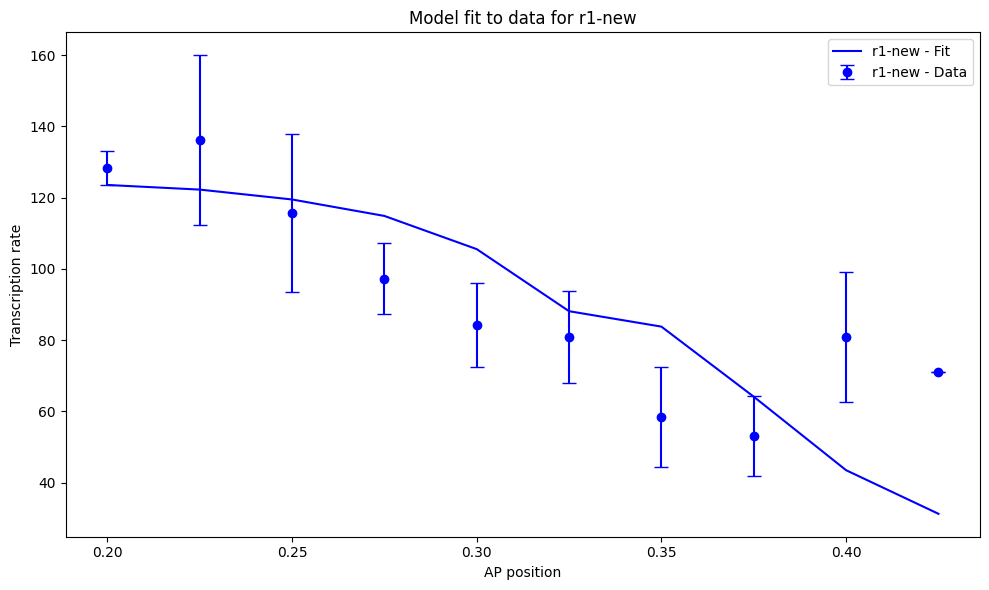

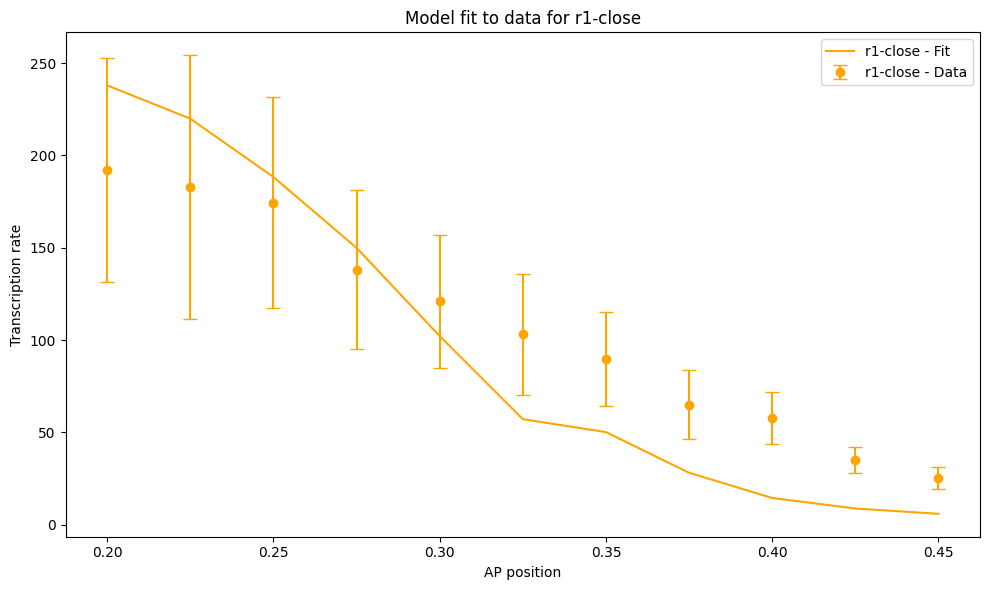

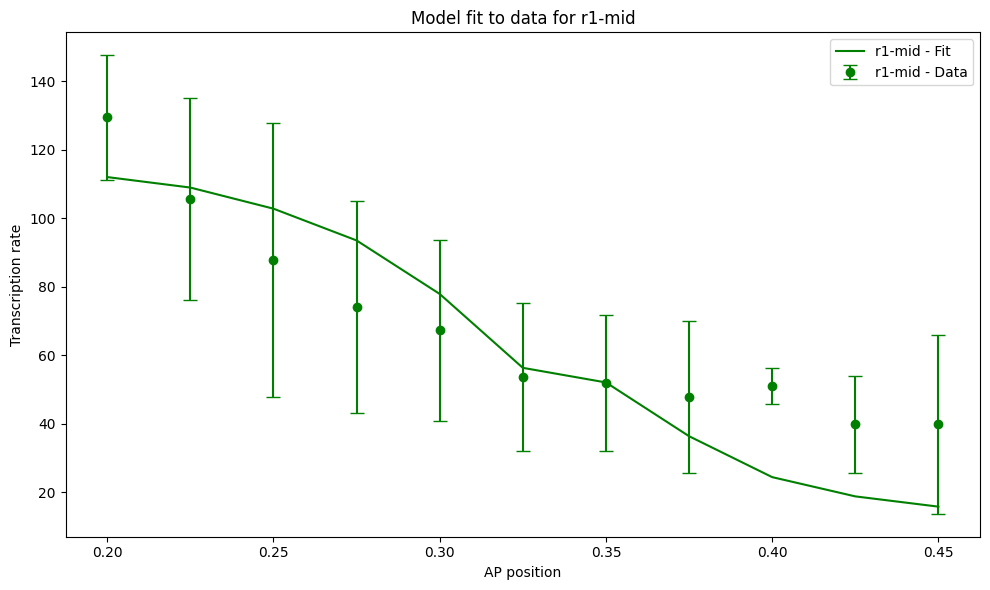

In [54]:
import matplotlib.pyplot as plt

# Define colors for the constructs
construct_colors = {
    'r1-new': 'blue',
    'r1-close': 'orange',
    'r1-mid': 'green'
}

# Iterate over constructs (r1-new, r1-close, r1-mid)
for construct_name in ['r1-new', 'r1-close', 'r1-mid']:
    data_dict = all_constructs_data[construct_name]
    Bcd = data_dict['Bcd']
    Runt = data_dict['Runt']
    Rate_WT_mean = data_dict['Rate_WT_mean']
    Rate_WT_std = data_dict['Rate_WT_std']
    APbins = data_dict['APbins']

    # Extract the inferred parameters for this construct
    theta_null = inferred_parameters[construct_name]
    R, p, K_b, w_bp = theta_null[:4]

    # Extract the shared K_r and individual w_rp for this construct
    K_r = theta_best_combined[0]
    w_rp = theta_best_combined[1 + ['r1-new', 'r1-close', 'r1-mid'].index(construct_name)]

    # Compute the model fit
    theta_full = [R, p, K_b, w_bp, K_r, w_rp]
    Rate_fit = model_1bs(theta_full, Bcd, Runt)

    # Create a new plot for each construct
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the data and the fit
    ax.errorbar(APbins, Rate_WT_mean, yerr=Rate_WT_std, fmt='o', 
                color=construct_colors[construct_name], 
                label=f'{construct_name} - Data', capsize=5)
    ax.plot(APbins, Rate_fit, color=construct_colors[construct_name], 
            label=f'{construct_name} - Fit')

    # Add labels and title
    ax.set_xlabel('AP position')
    ax.set_ylabel('Transcription rate')
    ax.set_title(f'Model fit to data for {construct_name}')
    ax.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()




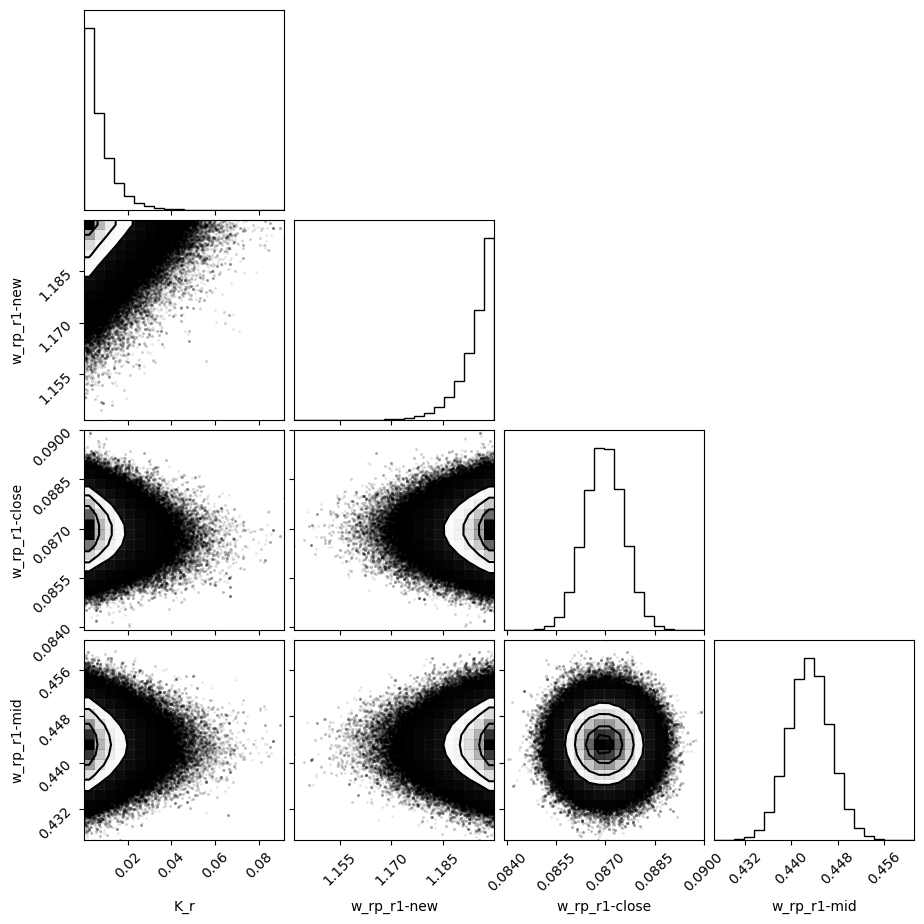

In [55]:
# Plot the corner plot for the combined fit
labels_combined = ['K_r'] + [f'w_rp_{construct_name}' for construct_name in ['r1-new', 'r1-close', 'r1-mid']]
fig_combined = corner.corner(samples_combined, labels=labels_combined)
plt.show()
